In [1]:
# Import the basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import the required datasets

calendar = pd.read_csv('C://Users/allan.abraham/Downloads/SeattleAirbnb/calendar.csv')
listings = pd.read_csv('C://Users/allan.abraham/Downloads/SeattleAirbnb/listings.csv')
reviews = pd.read_csv('C://Users/allan.abraham/Downloads/SeattleAirbnb/reviews.csv')

In [185]:
#EDA

In [3]:
calendar.shape[0]

1393570

In [4]:
calendar.shape[1]

4

In [5]:
reviews.columns[reviews.isnull().mean()>0.75]

Index([], dtype='object')

In [6]:
reviews.columns[reviews.isnull().mean()==0]

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name'], dtype='object')

In [7]:
listings.columns[listings.isnull().mean()>0.75]

Index(['square_feet', 'license'], dtype='object')

In [8]:
listings.columns[listings.isnull().mean()==0]

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'experiences_offered', 'picture_url', 'host_id', 'host_url',
       'host_verifications', 'street', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'room_type', 'accommodates', 'bed_type',
       'amenities', 'price', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped',
       'number_of_reviews', 'requires_license', 'jurisdiction_names',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count'],
      dtype='object')

In [9]:
calendar.columns[calendar.isnull().mean()>0.75]

Index([], dtype='object')

In [10]:
calendar.columns[calendar.isnull().mean()==0]

Index(['listing_id', 'date', 'available'], dtype='object')

In [11]:
available_calendar = calendar[calendar['available']=='t']

In [12]:
available_calendar.columns[available_calendar.isnull().mean()==0]

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

Text(0.5, 1.0, 'Bookings per listing')

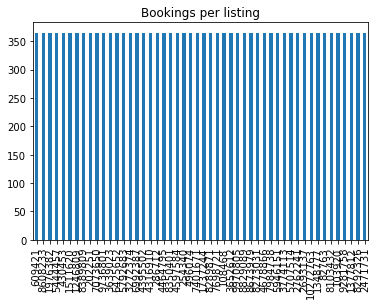

In [13]:
listing_vals = available_calendar.listing_id.value_counts()

#all listings
# (listing_vals/available_calendar.shape[0]).plot(kind='bar')

#top n listings
(listing_vals[:50]).plot(kind='bar')

plt.title("Bookings per listing")

In [186]:
# Data Prep for different data sources (Calendar, Listings, Reviews)

In [14]:
available_calendar['price'] = available_calendar['price'].str.replace('$', '').astype(str)
available_calendar['price'] = available_calendar['price'].str.replace(',', '').astype(float)

C:\Users\ALLAN~1.ABR\AppData\Local\Temp/ipykernel_18380/334025636.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  available_calendar['price'] = available_calendar['price'].str.replace('$', '').astype(str)
C:\Users\ALLAN~1.ABR\AppData\Local\Temp/ipykernel_18380/334025636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  available_calendar['price'] = available_calendar['price'].str.replace('$', '').astype(str)
C:\Users\ALLAN~1.ABR\AppData\Local\Temp/ipykernel_18380/334025636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [15]:
# result = pd.DataFrame(available_calendar.groupby('listing_id').agg({'price': ['min', 'max']})).reset_index()
# #result['diff']  = result['max'] - result['min']

# # result.rename(columns={'listing_id':'ID',('price','min'):'Min'})
# result['diff'] = result['price']['max'] - result['price']['min']

In [17]:
idx = available_calendar.groupby(['listing_id'])['date'].transform(max) == available_calendar['date']
newest = available_calendar[idx]

In [18]:
ids = available_calendar.groupby(['listing_id'])['date'].transform(min) == available_calendar['date']
oldest = available_calendar[ids]

In [109]:
#Finding if there was a price change in the airbnb
calendar_final = pd.merge(oldest, newest, on="listing_id")
calendar_final['diff'] = calendar_final['price_y'] - calendar_final['price_x']
calendar_final.drop(['date_x','date_y','price_x','price_y','available_x','available_y'],axis=1,inplace=True)
calendar_final

,listing_id,diff
0,241032,0.0
1,953595,275.0
2,3308979,0.0
3,7421966,0.0
4,278830,-150.0
...,...,...
3718,8101950,0.0
3719,8902327,27.0
3720,10267360,-18.0
3721,9604740,0.0


In [22]:
#Sentiment Analysis

In [77]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\allan.abraham\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\allan.abraham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [78]:
reviews["row_id"] = reviews.index + 1

In [79]:
#create a new data frame with "id" and "comment" fields
df_subset = reviews[['row_id','listing_id','comments']].copy()
#data clean-up
#remove all non-aphabet characters
df_subset['Response'] = df_subset['comments'].str.replace("[^a-zA-Z#]", " ")
#covert to lower-case
df_subset['Response'] = df_subset['Response'].str.casefold()
print (df_subset.head(10))

C:\Users\ALLAN~1.ABR\AppData\Local\Temp/ipykernel_18380/3820795433.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_subset['Response'] = df_subset['comments'].str.replace("[^a-zA-Z#]", " ")


   row_id  listing_id                                           comments  \
0       1     7202016  Cute and cozy place. Perfect location to every...   
1       2     7202016  Kelly has a great room in a very central locat...   
2       3     7202016  Very spacious apartment, and in a great neighb...   
3       4     7202016  Close to Seattle Center and all it has to offe...   
4       5     7202016  Kelly was a great host and very accommodating ...   
5       6     7202016  Kelly was great, place was great, just what I ...   
6       7     7202016  Kelly was great! Very nice and the neighborhoo...   
7       8     7202016  hola all bnb erz - Just left Seattle where I h...   
8       9     7202016  Kelly's place is conveniently located on a qui...   
9      10     7202016  The place was really nice, clean, and the most...   

                                            Response  
0  cute and cozy place  perfect location to every...  
1  kelly has a great room in a very central locat... 

In [80]:
## Change the reviews type to string
df_subset['reviews.text'] = df_subset['Response'].astype(str)

## Lowercase all reviews
df_subset['reviews.text'] = df_subset['reviews.text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [81]:
#Stop-words being most commonly used in the English language; however, these words have no predictive power in reality. Words such as I, me, myself, he, she, they, our, mine, you, yours etc.
stop = stopwords.words('english')
df_subset['reviews.text'] = df_subset['reviews.text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [82]:
# Stemming algorithm is very useful in the field of text mining and helps to gain relevant information as it reduces all words with the same roots to a common form by removing suffixes such as -action, ing, -es and -ses. However, there can be problematic where there are spelling errors.
st = PorterStemmer()
df_subset['reviews.text'] = df_subset['reviews.text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [84]:
## Define a function which can be applied to calculate the score for the whole dataset
def senti(x):
    return TextBlob(x).sentiment  

df_subset['senti_score'] = df_subset['reviews.text'].apply(senti)

df_subset.senti_score.head()

0                                  (0.75, 1.0)
1    (0.22321428571428573, 0.4928571428571429)
2                                 (0.7, 0.825)
3                                 (0.25, 0.35)
4     (0.5148148148148148, 0.5518518518518518)
Name: senti_score, dtype: object

In [62]:
# polarity = []
# subjectivity = []
# for i in range(len(df_subset)):
#     polarity.append(df_subset['senti_score'][i][0])
#     subjectivity.append(df_subset['senti_score'][i][1])

In [65]:
# df_subset['polarity'] = polarity
# df_subset['subjectivity'] = subjectivity

In [85]:
df_subset['polarity'] = df_subset['senti_score'].str.get(0)
df_subset['subjectivity'] = df_subset['senti_score'].str.get(1)

In [91]:
sentiment = pd.DataFrame(df_subset.groupby('listing_id').mean()).reset_index()
sentiment.drop('row_id', axis=1, inplace=True)

In [101]:
def assign_sentiment_score(k):
    if k > 0.5:
        return 1
    elif k <= 0:
        return -1
    else:
        return 0

In [113]:
#Assign a Sentiment based score to be used as one of the features for classifying
sentiment['pol_score'] = sentiment['polarity'].apply(assign_sentiment_score)
sentiment

,listing_id,polarity,subjectivity,pol_score
0,4291,0.384495,0.550949,0
1,5682,0.411016,0.610605,0
2,6606,0.377434,0.569910,0
3,7369,0.448791,0.592173,0
4,9419,0.325456,0.510719,0
...,...,...,...,...
3186,9995551,0.588889,0.816667,1
3187,10012724,0.225000,0.516667,0
3188,10020221,0.200000,0.655556,0
3189,10118341,0.400000,0.616270,0


In [110]:
def assign_price_change_score(k):
    if k > 0:
        return 1
    elif k < 0:
        return -1
    else:
        return 0

In [112]:
#Assign a score for change in price
calendar_final['price_score'] = calendar_final['diff'].apply(assign_price_change_score)
calendar_final

,listing_id,diff,price_score
0,241032,0.0,0
1,953595,275.0,1
2,3308979,0.0,0
3,7421966,0.0,0
4,278830,-150.0,-1
...,...,...,...
3718,8101950,0.0,0
3719,8902327,27.0,1
3720,10267360,-18.0,-1
3721,9604740,0.0,0


In [187]:
#Join all three data sources

In [126]:
listings_filt = listings[['id','city','state','zipcode','bathrooms','bedrooms','beds','price','amenities','review_scores_value','review_scores_rating','reviews_per_month']]
listings_filt

,id,city,state,zipcode,bathrooms,bedrooms,beds,price,amenities,review_scores_value,review_scores_rating,reviews_per_month
0,241032,Seattle,WA,98119,1.0,1.0,1.0,$85.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,95.0,4.07
1,953595,Seattle,WA,98119,1.0,1.0,1.0,$150.00,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",10.0,96.0,1.48
2,3308979,Seattle,WA,98119,4.5,5.0,7.0,$975.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,97.0,1.15
3,7421966,Seattle,WA,98119,1.0,0.0,2.0,$100.00,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN,NaN,NaN
4,278830,Seattle,WA,98119,2.0,3.0,3.0,$450.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",9.0,92.0,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,Seattle,WA,98107,2.0,3.0,3.0,$359.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",8.0,80.0,0.30
3814,8902327,Seattle,WA,98102,1.0,1.0,2.0,$79.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",10.0,100.0,2.00
3815,10267360,Seattle,WA,98178,1.0,1.0,1.0,$93.00,"{""Cable TV"",""Wireless Internet"",Kitchen,""Free ...",NaN,NaN,NaN
3816,9604740,Seattle,WA,98112,1.0,0.0,1.0,$99.00,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,NaN,NaN


In [130]:
listings_filt = listings_filt.dropna(subset=['id','city','state','zipcode','bathrooms','bedrooms','beds','price','amenities','review_scores_value','review_scores_rating','reviews_per_month'],how='any')
listings_filt['listing_id'] = listings_filt['id']
listings_filt.drop('id',axis=1,inplace=True)
listings_filt

,city,state,zipcode,bathrooms,bedrooms,beds,price,amenities,review_scores_value,review_scores_rating,reviews_per_month,listing_id
0,Seattle,WA,98119,1.0,1.0,1.0,$85.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,95.0,4.07,241032
1,Seattle,WA,98119,1.0,1.0,1.0,$150.00,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",10.0,96.0,1.48,953595
2,Seattle,WA,98119,4.5,5.0,7.0,$975.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,97.0,1.15,3308979
4,Seattle,WA,98119,2.0,3.0,3.0,$450.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",9.0,92.0,0.89,278830
5,Seattle,WA,98119,1.0,1.0,1.0,$120.00,"{""Wireless Internet"",""Free Parking on Premises...",10.0,95.0,2.45,5956968
...,...,...,...,...,...,...,...,...,...,...,...,...
3810,Seattle,WA,98103,1.0,2.0,3.0,$154.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",8.0,92.0,1.56,262764
3811,Seattle,WA,98103,1.0,1.0,1.0,$65.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,100.0,0.63,8578490
3812,Seattle,WA,98107,1.0,1.0,2.0,$95.00,"{Internet,""Wireless Internet"",Kitchen,""Free Pa...",10.0,96.0,4.01,3383329
3813,Seattle,WA,98107,2.0,3.0,3.0,$359.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",8.0,80.0,0.30,8101950


In [133]:
list_sent = pd.merge(listings_filt, sentiment, on="listing_id")
list_sent.drop(['polarity','subjectivity'],axis=1,inplace=True)
list_sent

,city,state,zipcode,bathrooms,bedrooms,beds,price,amenities,review_scores_value,review_scores_rating,reviews_per_month,listing_id,pol_score
0,Seattle,WA,98119,1.0,1.0,1.0,$85.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,95.0,4.07,241032,0
1,Seattle,WA,98119,1.0,1.0,1.0,$150.00,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",10.0,96.0,1.48,953595,0
2,Seattle,WA,98119,4.5,5.0,7.0,$975.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,97.0,1.15,3308979,0
3,Seattle,WA,98119,2.0,3.0,3.0,$450.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",9.0,92.0,0.89,278830,0
4,Seattle,WA,98119,1.0,1.0,1.0,$120.00,"{""Wireless Internet"",""Free Parking on Premises...",10.0,95.0,2.45,5956968,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,Seattle,WA,98103,1.0,2.0,3.0,$154.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",8.0,92.0,1.56,262764,0
3134,Seattle,WA,98103,1.0,1.0,1.0,$65.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,100.0,0.63,8578490,0
3135,Seattle,WA,98107,1.0,1.0,2.0,$95.00,"{Internet,""Wireless Internet"",Kitchen,""Free Pa...",10.0,96.0,4.01,3383329,0
3136,Seattle,WA,98107,2.0,3.0,3.0,$359.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",8.0,80.0,0.30,8101950,-1


In [136]:
df_final = pd.merge(list_sent,calendar_final,on="listing_id")
df_final.drop(['diff','price'],axis=1,inplace=True)
df_final

,city,state,zipcode,bathrooms,bedrooms,beds,amenities,review_scores_value,review_scores_rating,reviews_per_month,listing_id,pol_score,price_score
0,Seattle,WA,98119,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,95.0,4.07,241032,0,0
1,Seattle,WA,98119,1.0,1.0,1.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",10.0,96.0,1.48,953595,0,1
2,Seattle,WA,98119,4.5,5.0,7.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,97.0,1.15,3308979,0,0
3,Seattle,WA,98119,2.0,3.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",9.0,92.0,0.89,278830,0,-1
4,Seattle,WA,98119,1.0,1.0,1.0,"{""Wireless Internet"",""Free Parking on Premises...",10.0,95.0,2.45,5956968,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,Seattle,WA,98103,1.0,2.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",8.0,92.0,1.56,262764,0,1
3064,Seattle,WA,98103,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",10.0,100.0,0.63,8578490,0,1
3065,Seattle,WA,98107,1.0,1.0,2.0,"{Internet,""Wireless Internet"",Kitchen,""Free Pa...",10.0,96.0,4.01,3383329,0,0
3066,Seattle,WA,98107,2.0,3.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",8.0,80.0,0.30,8101950,-1,0


In [188]:
#Create the final dataframe and drop non numerics

In [151]:
df_final['amenities_count'] = df_final.amenities.str.count(',') + 1
df_final.drop('amenities',axis=1,inplace=True)
df_final

,city,state,zipcode,bathrooms,bedrooms,beds,review_scores_value,review_scores_rating,reviews_per_month,listing_id,pol_score,price_score,amenities_count
0,Seattle,WA,98119,1.0,1.0,1.0,10.0,95.0,4.07,241032,0,0,10
1,Seattle,WA,98119,1.0,1.0,1.0,10.0,96.0,1.48,953595,0,1,16
2,Seattle,WA,98119,4.5,5.0,7.0,10.0,97.0,1.15,3308979,0,0,21
3,Seattle,WA,98119,2.0,3.0,3.0,9.0,92.0,0.89,278830,0,-1,13
4,Seattle,WA,98119,1.0,1.0,1.0,10.0,95.0,2.45,5956968,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,Seattle,WA,98103,1.0,2.0,3.0,8.0,92.0,1.56,262764,0,1,22
3064,Seattle,WA,98103,1.0,1.0,1.0,10.0,100.0,0.63,8578490,0,1,15
3065,Seattle,WA,98107,1.0,1.0,2.0,10.0,96.0,4.01,3383329,0,0,19
3066,Seattle,WA,98107,2.0,3.0,3.0,8.0,80.0,0.30,8101950,-1,0,16


In [156]:
df_final['listing_id'] = df_final['listing_id'].astype(str)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3068 entries, 0 to 3067
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   city                  3068 non-null   object 
 1   state                 3068 non-null   object 
 2   zipcode               3068 non-null   object 
 3   bathrooms             3068 non-null   float64
 4   bedrooms              3068 non-null   float64
 5   beds                  3068 non-null   float64
 6   review_scores_value   3068 non-null   float64
 7   review_scores_rating  3068 non-null   float64
 8   reviews_per_month     3068 non-null   float64
 9   listing_id            3068 non-null   object 
 10  pol_score             3068 non-null   int64  
 11  price_score           3068 non-null   int64  
 12  amenities_count       3068 non-null   int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 400.1+ KB


In [169]:
df_final_new = df_final.select_dtypes(include=['int','float'])
df_final_new

,bathrooms,bedrooms,beds,review_scores_value,review_scores_rating,reviews_per_month,pol_score,price_score,amenities_count
0,1.0,1.0,1.0,10.0,95.0,4.07,0,0,10
1,1.0,1.0,1.0,10.0,96.0,1.48,0,1,16
2,4.5,5.0,7.0,10.0,97.0,1.15,0,0,21
3,2.0,3.0,3.0,9.0,92.0,0.89,0,-1,13
4,1.0,1.0,1.0,10.0,95.0,2.45,0,0,6
...,...,...,...,...,...,...,...,...,...
3063,1.0,2.0,3.0,8.0,92.0,1.56,0,1,22
3064,1.0,1.0,1.0,10.0,100.0,0.63,0,1,15
3065,1.0,1.0,2.0,10.0,96.0,4.01,0,0,19
3066,2.0,3.0,3.0,8.0,80.0,0.30,-1,0,16


In [170]:
# Apply Random Forest

In [195]:
X = df_final_new.drop('pol_score',axis=1)
y = df_final_new['pol_score']

In [196]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [197]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [198]:
rfc_pred = rfc.predict(X_test)

In [199]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,rfc_pred))

[[  0   5   0]
 [  0 825  11]
 [  0  76   4]]


In [200]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         5
           0       0.91      0.99      0.95       836
           1       0.27      0.05      0.08        80

    accuracy                           0.90       921
   macro avg       0.39      0.35      0.34       921
weighted avg       0.85      0.90      0.87       921



C:\Users\allan.abraham\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\allan.abraham\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\allan.abraham\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Here we tried to predict the sentiment received by an airbnb based on price change (gone up, down or hasn't changed), facilities provided, ammenities and ratings 